In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

## Functions used for generating binary images

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print('There is an error in the orient value')    
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    
    return binary_output
    

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely,abs_sobelx)
    
       
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    binary_output = np.uint8(binary_output)
    
    return binary_output

def hls_select(img,channel = 's', thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    if channel == 's':
        # 2) Apply a threshold to the S channel
        binary_output = np.zeros_like(S)
        binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    elif channel == 'h':
        binary_output = np.zeros_like(H)
        binary_output[(H > thresh[0]) & (H <= thresh[1])] = 1
    elif channel == 'l':
        binary_output = np.zeros_like(L)
        binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    else:
        print('There is an error in the channel value')
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

## Functions from the simple lane finding project

In [3]:
import math

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# hough_lines modified to return also the lines it calculates as an array
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# function to avoid division by zero
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

def average_lines(lines,imshape,filt_coeff=1,height_coeff=0.7):
    """
    This function gets the lines provided by hough transform as input. 
    The lines are into two groups, one group contains lines on the left side of car 
    and the other contains lines on the right side of the car. The group is filtered
    based on the mean and the average parameters of the lines are calculated. This is 
    used to draw the extrapolated lines on the image
        
    """
    lines = lines[:,0,:]    
    lines_left = []
    lines_right = []       
    
    for x1,y1,x2,y2 in lines:
        """
         safe_div function is to calculate slope returns zero slope in case of 
         line parallel to yaxis. Though it is wrong these lines are not interesting 
         and it will be ignored                  
        """
                
        slope = safe_div((y2-y1),(x2-x1)) 
        x_intercept = y1-slope*x1
        #x0 = float((y0-x_intercept)/slope)
        if slope < 0:  
            lines_left.append([slope,x_intercept])            
        elif slope > 0:
            lines_right.append([slope,x_intercept]) 
            
    left_lines = np.asarray(lines_left)
    right_lines = np.asarray(lines_right)       
    
    mean_left = np.mean(left_lines,axis=0)
    mean_right = np.mean(right_lines,axis=0)
    
    filt_left_lines = []
    filt_right_lines =  []
    
    for line in lines_left:
        diff = math.fabs((mean_left[0] - line[0])/mean_left[0])        
        if diff < filt_coeff:
            filt_left_lines.append(line)
    for line in lines_right:
        diff = math.fabs((mean_right[0]- line[0])/mean_right[0])
        if diff < filt_coeff:
            filt_right_lines.append(line)
            
    filt_left_lines = np.array(filt_left_lines)
    filt_right_lines = np.array(filt_right_lines)
    
    if len(filt_left_lines)>0:
        mean_left = np.mean(filt_left_lines,axis=0)
    if len(filt_right_lines)>0:
        mean_right = np.mean(filt_right_lines,axis=0)
    
    y1 = imshape[0]*0.95
    y2 = imshape[0]*height_coeff  
    
    x1_left = (y1-mean_left[1])/mean_left[0]
    x2_left = (y2-mean_left[1])/mean_left[0]
    
    x1_right = (y1-mean_right[1])/mean_right[0]
    x2_right = (y2-mean_right[1])/mean_right[0]
    
    mean_lines = np.array(([[[x1_left,y1,x2_left,y2]],[[x1_right,y1,x2_right,y2]]]),dtype=np.int32)
    mean_lines_img = np.zeros((imshape[0], imshape[1], 3), dtype=np.uint8)
    draw_lines(mean_lines_img, mean_lines,color=[255, 0, 0], thickness=7)
    
    lane_lines = np.array([[x1_left,y1],[x2_left,y2],[x2_right,y2],[x1_right,y1]],dtype = np.int32)
    
    return mean_lines_img,lane_lines

## Sliding window function to identify lane from warped image

In [4]:
def FindLanesSlidingWindow(binary_warped,nwindows = 9,margin = 100,minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices

    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit,out_img

## Function to find lanes once it is available for previous image

In [5]:
def SearchLanes(binary_warped,left_fit,right_fit,margin = 100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit

## Functions to find radius and center of car

In [6]:
def FindCarCenter(left_fitx,right_fitx,img_shape,xm_per_pix = 3.7/700):
    # -ve values represent car is on left to the center and +ve represent car on right
    road_center=(right_fitx[img_shape[0]-1]-left_fitx[img_shape[0]-1])/2+left_fitx[img_shape[0]-1]
    car_center = img_shape[1]/2
    difference_pixels = (car_center - road_center)
    difference_meters = difference_pixels*3.7/700
    
    return difference_meters

def FindRadiusOfCurvature(ploty,left_fitx,right_fitx,ym_per_pix = 30/720,xm_per_pix = 3.7/700):
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad,right_curverad

def PlausiblityCheck(ploty,left_fitx,right_fitx,TestObj):
    y_max = int(max(ploty))
    y_min = int(min(ploty))
    y_mid = int(np.mean(ploty))
    lane_width_top = right_fitx[y_min] - left_fitx[y_min] 
    lane_width_bottom = right_fitx[y_max] - left_fitx[y_max] 
    width_difference = lane_width_bottom - lane_width_top
    
    if (width_difference < 50 and width_difference > -50) and (lane_width_top > 100 and lane_width_bottom > 100):
        
        result = True
    else:
        result = False
        
    return result
    
    
    

In [7]:
def displayImage(undist,ploty,left_fitx,right_fitx,Minv,left_curverad,right_curverad,difference_meters,src, warp = False):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    Lines_Img = np.zeros_like(undist).astype(np.uint8)       
    cv2.line(Lines_Img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(255,0,0),5)
    cv2.line(Lines_Img,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(255,0,0),5)
       
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    
       
    if warp == False:
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
        # Combine the result with the original image
        newwarp = cv2.addWeighted(newwarp,1,Lines_Img,1,0)
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    else:
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(undist, Minv, (undist.shape[1], undist.shape[0])) 
        # Combine the result with the original image
        newwarp = cv2.addWeighted(newwarp,1,Lines_Img,1,0)
        result = cv2.addWeighted(newwarp, 1, color_warp, 0.3, 0)
    
    curvature = min(left_curverad,right_curverad)
    text1 = 'Radius of the curvature of the inside lane: '+ str(curvature) + ' m'
    text2 = 'Lateral distance of the car from road center: ' + str(difference_meters)+ ' m'
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,text1,(10,60), font, 1,(255,255,255),2)
    cv2.putText(result,text2,(10,120), font, 1,(255,255,255),2)
    
    return result
    

In [8]:
class Test:
    def __init__(self):
        
        self.src =[]
        self.dst =[]
        self.left_fit = []
        self.right_fit = []
        self.reset = 0
        self.PlausiblityFlag = True
        self.right_curverad = 0
        self.left_curverad = 0
        self.M = []
        self.Minv=[]
        self.ploty = []


## Main function to process image

In [9]:
with open('CameraCalibration.p','rb') as f:
    data = pickle.load(f)
mtx = data[1]
dist = data[2]
TestObj = Test()

def process_image(img):             
           
    global mtx
    global dist
    global TestObj
    
    # Undistorting image:
    undist = cv2.undistort(img, mtx, dist, None)
    
    ksize = 5
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(50, 250))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(50, 250))
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(70, 250))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(np.pi*30./180,np.pi*80./180))
    s_binary = hls_select(undist,channel = 's', thresh=(150, 255))
    l_binary = hls_select(undist,channel = 'l', thresh=(50, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1))|((mag_binary == 1) & (dir_binary == 1))|((s_binary == 1)&(l_binary==1))] = 255
    
    offset = 40
    arrOffset = np.array([[-offset,0],[-offset,0],[offset,0],[offset,0]],dtype='int32')
    
    if TestObj.reset == 0 or TestObj.PlausiblityFlag == False :
        
        imshape = img.shape
        width = imshape[1]
        height = imshape[0]
        #combined = np.uint8(combined)*255
        height_prm = 0.11
        width_prm = 0.06
        vertices = np.array([[(width_prm*width,height*(1-height_prm/2)),(width*(0.5-width_prm),height*(0.5+height_prm)),
                              (width*(0.5+width_prm),height*(0.5+height_prm)),(width*(1-width_prm),height*(1-height_prm/2))]], dtype=np.int32)
        # masking the image from canny edge algorithm
        masked_edges = region_of_interest(combined,vertices)
        
        rho = 2 # distance resolution in pixels of the Hough grid
        theta = np.pi/180 # angular resolution in radians of the Hough grid
        threshold = 50     # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 40 #minimum number of pixels making up a line
        max_line_gap = 20    # maximum gap in pixels between connectable line segments
        [line_img,lines] = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)
        
        try:
                
            mean_line_img,lane_lines =  average_lines(lines,imshape,height_coeff=0.6)                    
            src = lane_lines + arrOffset
            #src = lane_lines
        except:
            
            src = TestObj.src
            
        x1_dst = src[0][0]
        x2_dst = src[3][0]

        y1_dst = src[0][1]
        y2_dst = src[1][1]

        dst = np.array([[x1_dst,y1_dst],[x1_dst,y2_dst],[x2_dst,y2_dst],[x2_dst,y1_dst]],dtype='int32')
        
        TestObj.src = src
        TestObj.dst = dst
    
    img_size = (img.shape[1],img.shape[0])
    
    M = cv2.getPerspectiveTransform(np.float32(TestObj.src),np.float32(TestObj.dst))
    Minv = cv2.getPerspectiveTransform(np.float32(TestObj.dst),np.float32(TestObj.src))
    image_warped = cv2.warpPerspective(combined,M,img_size,flags=cv2.INTER_LINEAR)
    
    TestObj.M = M
    TestObj.Minv = Minv
    
    if TestObj.reset == 0 or TestObj.PlausiblityFlag == False:
        
        TestObj.left_fit,TestObj.right_fit,out_windows = FindLanesSlidingWindow(image_warped)
    
    else:
        TestObj.left_fit,TestObj.right_fit = SearchLanes(image_warped,TestObj.left_fit,TestObj.right_fit)   
   
    
    ploty = np.linspace(0, image_warped.shape[0]-1, image_warped.shape[0] )
    left_fitx = TestObj.left_fit[0]*ploty**2 + TestObj.left_fit[1]*ploty + TestObj.left_fit[2]
    right_fitx = TestObj.right_fit[0]*ploty**2 + TestObj.right_fit[1]*ploty + TestObj.right_fit[2]
    
    TestObj.ploty = ploty
    
    center_distance = FindCarCenter(left_fitx,right_fitx,(img.shape[0],img.shape[1]))
    left_curverad,right_curverad = FindRadiusOfCurvature(ploty,left_fitx,right_fitx)
    
    TestObj.right_curverad = right_curverad
    TestObj.left_curverad = left_curverad
    
        
    TestObj.PlausiblityFlag = PlausiblityCheck(ploty,left_fitx,right_fitx,TestObj)
    
    #result = displayImage(undist, ploty, left_fitx, right_fitx, Minv, left_curverad, right_curverad, TestObj.PlausiblityFlag,(TestObj.src-arrOffset))
    result = displayImage(undist, ploty, left_fitx, right_fitx, M, left_curverad, right_curverad,TestObj.PlausiblityFlag,TestObj.dst,warp = True)    
       
    TestObj.reset = 1
    
    return(result)
    
        
    

In [10]:
img = cv2.imread('./test_images/test5.jpg')
#img_2 = cv2.imread('./test_images/test6.jpg')
TestObj =Test()
#TestObj.reset = 1
#output = process_image(img,mtx,dist,TestObj1)
output = process_image(img)
#output_2 = process_image(img_2)

In [11]:
output.min()

0

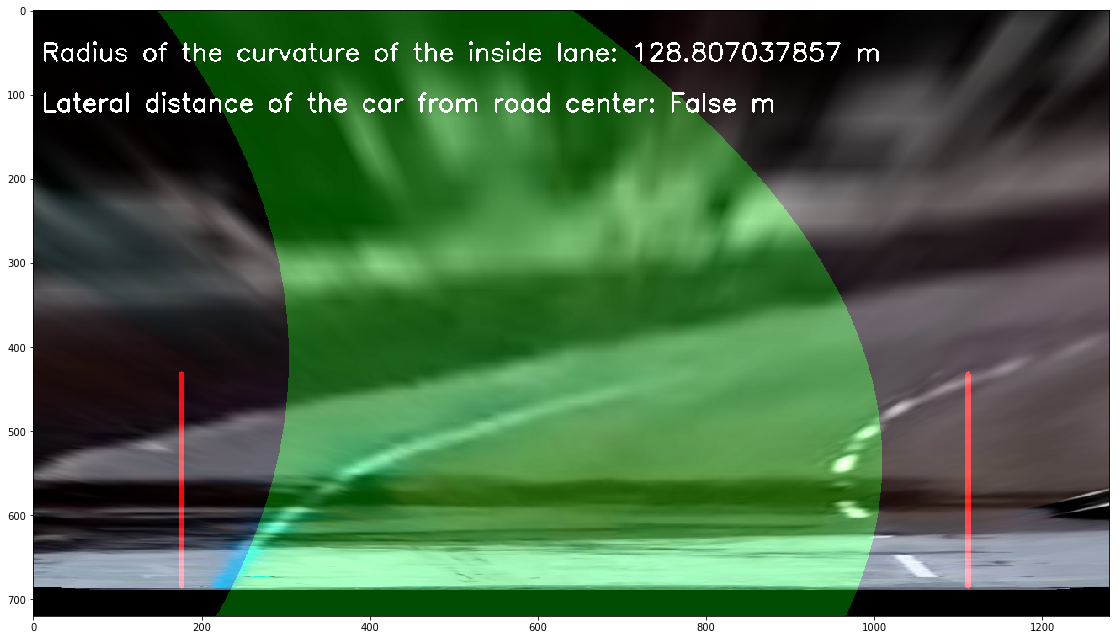

In [12]:
#x_ticks = np.linspace(0, img.shape[1], 30 )
#y_ticks = np.linspace(0, img.shape[0], 20 )
f,ax1 = plt.subplots(1,figsize=(24, 9))
f.tight_layout()
ax1.imshow(output)
#ax1.set_xticks(x_ticks)
#ax1.set_yticks(y_ticks)

In [13]:
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = TestObj.left_fit[0]*ploty**2 + TestObj.left_fit[1]*ploty + TestObj.left_fit[2]
right_fitx = TestObj.right_fit[0]*ploty**2 + TestObj.right_fit[1]*ploty + TestObj.right_fit[2]
y_max = int(max(ploty))
y_min = int(min(ploty))
y_mid = int(np.mean(ploty))
lane_width_bottom = right_fitx[y_max] - left_fitx[y_max] 
lane_width_top = right_fitx[y_min] - left_fitx[y_min] 
width_difference = lane_width_top - lane_width_bottom
PlausiblityCheck(ploty,left_fitx,right_fitx,TestObj)

False

In [14]:
(width_difference < 50 and width_difference > -50) and (lane_width_top > 100 and lane_width_bottom > 100)

False

In [15]:
width_difference

-254.5468155546252

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_output_warped.mp4'
clip1 = VideoFileClip('project_video.mp4')

TestObj = Test()
#TestObj.reset = 0

write_clip = clip1.fl_image(process_image)

%time write_clip.write_videofile(write_output, audio=False)


[MoviePy] >>>> Building video project_video_output_warped.mp4
[MoviePy] Writing video project_video_output_warped.mp4


100%|█████████▉| 1260/1261 [04:00<00:00,  5.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_warped.mp4 

Wall time: 4min 1s


In [17]:
TestObj.src

array([[ 300,  684],
       [ 592,  432],
       [ 687,  432],
       [1201,  684]])

In [18]:
if (TestObj.right_curverad < TestObj.left_curverad):    
    
        offset = width_difference * 0.1
        arrOffset = np.array([[0,0],[offset,0],[0,0],[0,0]],dtype='int32')
        TestObj.src -= arrOffset    
else:
        offset = width_difference * 0.1
        arrOffset = np.array([[0,0],[0,0],[offset,0],[0,0]],dtype='int32')
        TestObj.src -= arrOffset    
        

In [19]:
TestObj.src

array([[ 300,  684],
       [ 617,  432],
       [ 687,  432],
       [1201,  684]])

In [20]:
width_difference * 0.1

-25.454681555462521

In [21]:
TestObj.dst

array([[ 300,  684],
       [ 300,  432],
       [1201,  432],
       [1201,  684]])

In [22]:
x = np.dot(TestObj.Minv,np.array([237,503,1]))
x = x/x[2]
x

array([ 571.52162802,  442.0087148 ,    1.        ])

In [23]:
y1 = y_max
y2 = y_min
x1 = np.polyval(TestObj.left_fit,y1)
x2 = np.polyval(TestObj.left_fit,y2)
x3 = np.polyval(TestObj.right_fit,y1)
x4 = np.polyval(TestObj.right_fit,y2)
dst = np.array([[x1,y1],[x2,y2],[x4,y2],[x3,y1]],dtype = 'float32')
src = []
for i in range(len(dst)):
    point = np.dot(TestObj.Minv,[dst[i][0],dst[i][1],1])
    point = point/point[2]
    src.append([point[0],point[1]])
src = np.array(src,dtype = 'float32')
    

In [24]:
dst

array([[  341.70001221,   719.        ],
       [  419.6862793 ,     0.        ],
       [ 1372.21240234,     0.        ],
       [ 1199.05505371,   719.        ]], dtype=float32)

In [25]:
src

array([[ 2222.69824219, -1177.08190918],
       [  617.81335449,   414.02139282],
       [  657.45471191,   414.02139282],
       [-2584.11206055, -1177.08190918]], dtype=float32)

In [26]:
TestObj.src = src
TestObj.dst = dst

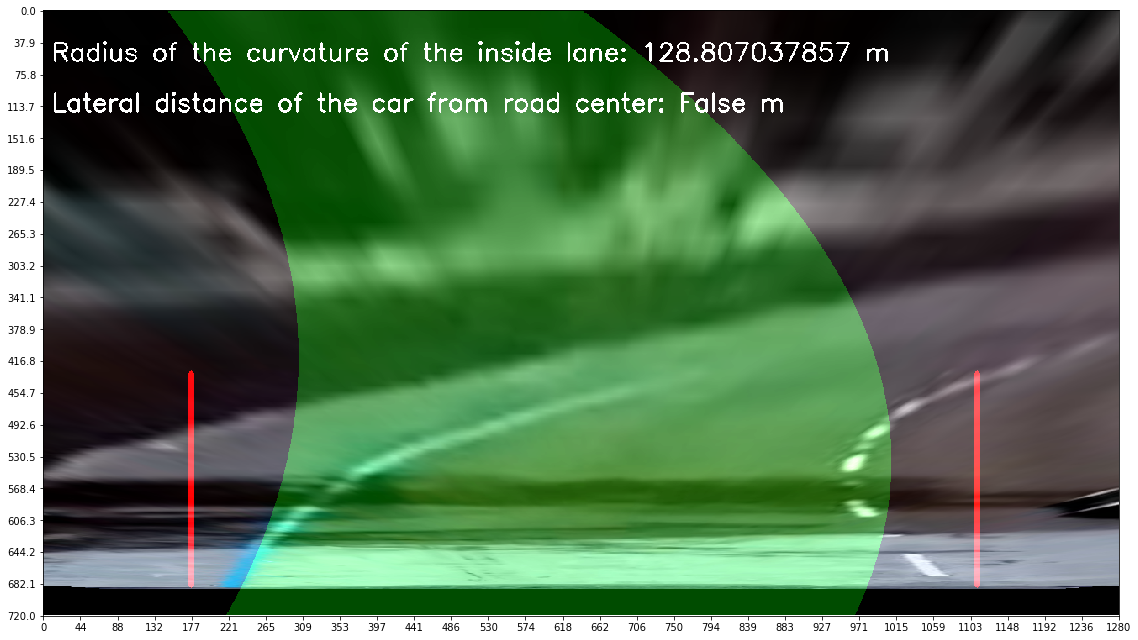

In [27]:
output = process_image(img)
x_ticks = np.linspace(0, img.shape[1], 30 )
y_ticks = np.linspace(0, img.shape[0], 20 )
f,ax1 = plt.subplots(1,figsize=(24, 9))
f.tight_layout()
ax1.imshow(output)
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)